In [635]:
import itertools
import random

import torch
from torch.nn import Linear
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing, TopKPooling
from torch_geometric.transforms import NormalizeFeatures
from torch_scatter import scatter_mean
from collections import defaultdict

from custom.args import grey, purple
from custom.dataset import GraphDataset, create_dataset
from custom.utils import *
from networkx.algorithms.centrality import degree_centrality

In [550]:
class GraphMatchingConvolution(MessagePassing):
    def __init__(self, in_channels, out_channels, args, aggr="add"):
        super(GraphMatchingConvolution, self).__init__(aggr=aggr)
        self.args = args
        self.lin_node = torch.nn.Linear(in_channels, out_channels)
        self.lin_message = torch.nn.Linear(out_channels * 2, out_channels)
        self.lin_passing = torch.nn.Linear(out_channels + in_channels, out_channels)
        self.batch_norm = BatchNorm(out_channels)

    def forward(self, x, edge_index, batch):
        x_transformed = self.lin_node(x)
        return self.propagate(edge_index, x=x_transformed, original_x=x, batch=batch)

    def message(self, edge_index_i, x_i, x_j):
        x = torch.cat([x_i, x_j], dim=1)
        m = self.lin_message(x)
        return m

    def update(self, aggr_out, edge_index, x, original_x, batch):
        n_graphs = torch.unique(batch).shape[0]
        cross_graph_attention, a_x, a_y = batch_block_pair_attention(
            original_x, batch, n_graphs
        )
        attention_input = original_x - cross_graph_attention
        aggr_out = self.lin_passing(torch.cat([aggr_out, attention_input], dim=1))
        aggr_out = self.batch_norm(aggr_out)

        norms = torch.norm(aggr_out, p=2, dim=1)
        cross_attention_sums = cross_graph_attention.sum(dim=1)

        return (
            aggr_out,
            edge_index,
            batch,
            (
                attention_input,
                cross_graph_attention,
                a_x,
                a_y,
                norms,
                cross_attention_sums,
            ),
        )


class GraphAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels, args):
        super(GraphAggregator, self).__init__()
        self.lin = torch.nn.Linear(in_channels, out_channels)
        self.lin_gate = torch.nn.Linear(in_channels, out_channels)
        self.lin_final = torch.nn.Linear(out_channels, out_channels)
        self.args = args

    def forward(self, x, edge_index, batch):
        x_states = self.lin(x)
        x_gates = torch.nn.functional.softmax(self.lin_gate(x), dim=1)
        x_states = x_states * x_gates
        x_states = scatter_mean(x_states, batch, dim=0)
        x_states = self.lin_final(x_states)
        return x_states


class GraphMatchingNetwork(torch.nn.Module):
    def __init__(self, args):
        super(GraphMatchingNetwork, self).__init__()
        self.args = args
        self.margin = self.args.margin
        if args.n_classes > 2:
            self.f1_average = "micro"
        else:
            self.f1_average = "binary"
        self.layers = torch.nn.ModuleList()
        self.layers.append(
            GraphMatchingConvolution(self.args.feat_dim, self.args.dim, args)
        )
        for _ in range(self.args.num_layers - 1):
            self.layers.append(
                GraphMatchingConvolution(self.args.dim, self.args.dim, args)
            )
        self.aggregator = GraphAggregator(self.args.dim, self.args.dim, self.args)
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.mincut = []
        self.mlp = torch.nn.Sequential()
        self.args.n_clusters = args.n_clusters
        self.mlp.append(Linear(self.args.dim, self.args.n_clusters))
        self.topk_outputs = []
        self.norms_per_layer = []
        self.attention_sums_per_layer = []

    def compute_emb(
        self, feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
    ):

        topk_pooling = TopKPooling(
            self.args.dim, ratio=min(sizes_1.item(), sizes_2.item())
        )
        for i in range(self.args.num_layers):
            (
                feats,
                edge_index,
                batch,
                (
                    attention_input,
                    cross_graph_attention,
                    a_x,
                    a_y,
                    norms,
                    attention_sums,
                ),
            ) = self.layers[i](feats, edge_index, batch)

            x_1 = feats[: sizes_1.item(), :]
            x_2 = feats[sizes_1.item() : sizes_1.item() + sizes_2.item(), :]

            norms_1 = norms[: sizes_1.item()]
            norms_2 = norms[sizes_1.item() : sizes_1.item() + sizes_2.item()]

            attention_sums_1 = attention_sums[: sizes_1.item()]
            attention_sums_2 = attention_sums[
                sizes_1.item() : sizes_1.item() + sizes_2.item()
            ]

            x_pooled_1, edge_index_pooled_1, _, _, perm1, score1 = topk_pooling(
                x_1,
                edge_index_1,
            )
            x_pooled_2, edge_index_pooled_2, _, _, perm2, score2 = topk_pooling(
                x_2,
                edge_index_2,
            )

            self.topk_outputs.append(
                (
                    (x_pooled_1, edge_index_pooled_1, perm1, score1),
                    (x_pooled_2, edge_index_pooled_2, perm2, score2),
                )
            )
            self.layer_cross_attentions.append((cross_graph_attention, a_x, a_y))
            self.layer_outputs.append((x_1, edge_index_1, x_2, edge_index_2))
            self.norms_per_layer.append((norms_1, norms_2))
            self.attention_sums_per_layer.append((attention_sums_1, attention_sums_2))

        feats = self.aggregator(feats, edge_index, batch)
        return feats, edge_index, batch

    def combine_pair_embedding(
        self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
    ):
        feats = torch.cat([feats_1, feats_2], dim=0)
        max_node_idx_1 = sizes_1.sum()
        edge_index_2_offset = edge_index_2 + max_node_idx_1
        edge_index = torch.cat([edge_index_1, edge_index_2_offset], dim=1)
        batch = create_batch(torch.cat([sizes_1, sizes_2], dim=0))
        feats, edge_index, batch = (
            feats.to(self.args.device),
            edge_index.to(self.args.device),
            batch.to(self.args.device),
        )
        return feats, edge_index, batch

    def forward(self, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2):
        self.layer_outputs = []
        self.layer_cross_attentions = []
        self.topk_outputs = []
        self.mincut = []
        self.norms_per_layer = []
        self.attention_sums_per_layer = []

        feats, edge_index, batch = self.combine_pair_embedding(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )
        emb, _, _ = self.compute_emb(
            feats, edge_index, batch, sizes_1, sizes_2, edge_index_1, edge_index_2
        )
        emb_1 = emb[: emb.shape[0] // 2, :]
        emb_2 = emb[emb.shape[0] // 2 :, :]

        best_acc1, best_acc2 = 0.0, 0.0
        cluster1, cluster2 = None, None
        layer1, layer2 = None, None
        clusters = []

        return emb_1, emb_2, cluster1, cluster2, layer1, layer2

    def compute_metrics(self, emb_1, emb_2, labels):
        distances = torch.norm(emb_1 - emb_2, p=2, dim=1)
        loss = F.relu(self.margin - labels * (1 - distances)).mean()
        predicted_similar = torch.where(
            distances < self.args.margin,
            torch.ones_like(labels),
            -torch.ones_like(labels),
        )
        acc = (predicted_similar == labels).float().mean()
        metrics = {"loss": loss, "acc": acc}
        return metrics

    def init_metric_dict(self):
        return {"acc": -1, "f1": -1}

    def has_improved(self, m1, m2):
        return m1["acc"] < m2["acc"]

Total number of graphs: 188
Number of classes: 2
Number of node features: 7
Average number of nodes per graph: 17
Max number of nodes in a graph: 28
Min number of nodes in a graph: 10
Class distribution:
 - Class 1: 125 graphs (66.49%)
 - Class 0: 63 graphs (33.51%)


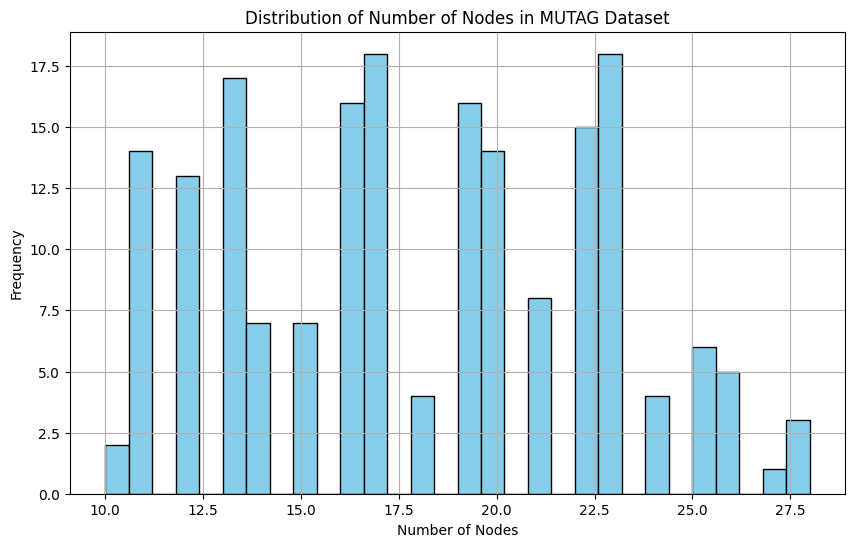

Small graphs: 114
Medium graphs: 74
Large graphs: 0


In [636]:
dataset = TUDataset(
    root="data", name="MUTAG", use_node_attr=True, transform=NormalizeFeatures()
)


(
    small_graphs,
    medium_graphs,
    large_graphs,
    classes,
    small_classes,
    medium_classes,
    large_classes,
) = analyze_dataset(dataset)

In [552]:
def train(model, optimizer, pairs, labels, batch_size, title):
    model.train()
    train_losses = []
    train_accuracies = []
    losses = []
    accs = []
    print(f"pairs: {len(pairs)}, batch_size: {batch_size}")

    def get_params(model):
        return {name: param.clone() for name, param in model.named_parameters()}

    initial_params = get_params(model)

    for i in range(len(pairs)):
        optimizer.zero_grad()

        graph1, graph2 = pairs[i]
        label = labels[i]

        feats_1, edge_index_1 = graph1.x, graph1.edge_index
        feats_2, edge_index_2 = graph2.x, graph2.edge_index
        sizes_1 = torch.tensor([graph1.num_nodes])
        sizes_2 = torch.tensor([graph2.num_nodes])

        emb_1, emb_2, _, _, _, _ = model(
            feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
        )

        metrics = model.compute_metrics(emb_1, emb_2, torch.tensor([label]))
        loss = metrics["loss"]
        acc = metrics["acc"]

        losses.append(loss)
        accs.append(acc)

        if i % batch_size == 0 and i > 0:
            batch_loss = torch.mean(torch.stack(losses))
            batch_acc = torch.mean(torch.stack(accs))
            losses = []
            accs = []
            train_losses.append(batch_loss.detach().numpy())
            train_accuracies.append(batch_acc.detach().numpy())
            batch_loss.backward()
            optimizer.step()
            # if i % 100 * batch_size == 0:
            #     print(
            #         f"Epoch: {i} - Loss: {batch_loss.item():.4f}, Acc: {batch_acc:.4f}"
            #     )

    trained_params = get_params(model)

    # for name in initial_params:
    #     initial_param = initial_params[name]
    #     trained_param = trained_params[name]
    #     if not torch.equal(initial_param, trained_param):
    #         print(f"Parameter {name} has changed.")
    #     else:
    #         print(f"Parameter {name} has NOT changed.")

    plt.figure(figsize=(12, 5))
    plt.title(title)

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="Training Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

In [553]:
def best_k(model, threshold=0.8):
    def calculate_cumulative_scores(scores):
        normalized_scores = F.softmax(scores, dim=0)
        cumulative_scores = torch.cumsum(normalized_scores, dim=0)
        return cumulative_scores

    def calculate_confidence(cumulative_scores, k):
        gradients = np.gradient(cumulative_scores.detach().numpy())
        confidence = gradients[k - 1]
        return confidence

    def find_best_k_and_confidence(cumulative_scores, total_percentage):
        k = ((cumulative_scores / cumulative_scores[-1]) >= total_percentage).nonzero()[
            0
        ].item() + 1
        confidence = calculate_confidence(cumulative_scores, k)
        return k, confidence

    layer_scores_1 = []
    layer_scores_2 = []
    for i in range(len(model.topk_outputs)):
        (
            (_, _, _, score1),
            (_, _, _, score2),
        ) = model.topk_outputs[i]
        layer_scores_1.append(score1)
        layer_scores_2.append(score2)

    k_values_graph1 = []
    confidences_graph1 = []
    for i, scores in enumerate(layer_scores_1):
        cumulative_scores = calculate_cumulative_scores(scores)
        best_k, confidence = find_best_k_and_confidence(cumulative_scores, threshold)
        k_values_graph1.append(best_k)
        confidences_graph1.append(confidence)

    k_values_graph2 = []
    confidences_graph2 = []
    for i, scores in enumerate(layer_scores_2):
        cumulative_scores = calculate_cumulative_scores(scores)
        best_k, confidence = find_best_k_and_confidence(cumulative_scores, threshold)
        k_values_graph2.append(best_k)
        confidences_graph2.append(confidence)

    def calculate_weighted_average(ks, confidences):
        normalized_confidences = [float(i) / sum(confidences) for i in confidences]
        weighted_ks = sum(k * w for k, w in zip(ks, normalized_confidences))
        return int(round(weighted_ks))

    combined_ks = k_values_graph1 + k_values_graph2
    combined_confidences = confidences_graph1 + confidences_graph2

    overall_k_confidence = calculate_weighted_average(combined_ks, combined_confidences)
    # overall_k_median = int(np.median(combined_ks))

    return overall_k_confidence

In [554]:
def calculate_weighted_confidence(scores, external_weights=None, w_avg=0.5, w_var=0.5):
    average_score = scores.mean()

    variance_score = scores.var()

    if variance_score == 0:
        inverse_variance = torch.tensor(0)
    else:
        inverse_variance = 1 / variance_score

    weighted_confidence = w_avg * average_score + w_var * inverse_variance

    if external_weights is not None:
        weighted_confidence += external_weights.sum() * 0.1

    return weighted_confidence.item()

In [555]:
def most_isomorphic(a_pyg, b_pyg):
    a = [to_networkx(g, to_undirected=True) for g in a_pyg]
    b = [to_networkx(g, to_undirected=True) for g in b_pyg]
    isomorphism_counts = [0] * len(a)
    for i, g1 in enumerate(a):
        for g2 in b:
            if nx.is_isomorphic(g1, g2):
                isomorphism_counts[i] += 1
    max_index = isomorphism_counts.index(max(isomorphism_counts))
    return a_pyg[max_index]

In [556]:
def find_min_total_ged_graph(graphs):
    nx_graphs = [to_networkx(graph, to_undirected=True) for graph in graphs]

    total_geds = [0] * len(nx_graphs)

    for i, graph_i in enumerate(nx_graphs):
        for j, graph_j in enumerate(nx_graphs):
            if i != j:
                min_ged = float("inf")
                for ged_estimate in nx.optimize_graph_edit_distance(graph_i, graph_j):
                    min_ged = min(min_ged, ged_estimate)
                total_geds[i] += min_ged

    min_ged_index = total_geds.index(min(total_geds))

    return graphs[min_ged_index]

In [557]:
def remove_double_edges(edge_index):
    edge_list = edge_index.t()
    unique_edges = torch.unique(edge_list, dim=0)
    return unique_edges.t()

In [558]:
def combine_graphs(graph1, graph2, mapping, ratio=0.5):
    x1, edge_index1 = graph1.x, graph1.edge_index
    x2, edge_index2 = graph2.x, graph2.edge_index

    new_x_size = x1.size(0) + x2.size(0) - len(mapping)
    new_x = torch.zeros((new_x_size, x1.size(1)))

    new_index_map = {}
    current_index = 0

    for idx1, idx2 in mapping.items():
        new_x[current_index] = (x1[idx1] + x2[idx2]) * ratio
        new_index_map[idx1] = current_index
        new_index_map[x1.size(0) + idx2] = current_index
        current_index += 1

    for idx1 in range(x1.size(0)):
        if idx1 not in mapping:
            new_x[current_index] = x1[idx1]
            new_index_map[idx1] = current_index
            current_index += 1

    for idx2 in range(x2.size(0)):
        if idx2 not in mapping.values():
            new_x[current_index] = x2[idx2]
            new_index_map[x1.size(0) + idx2] = current_index
            current_index += 1

    new_edge_list = []
    for edge in edge_index1.t():
        new_edge_list.append(
            [new_index_map[edge[0].item()], new_index_map[edge[1].item()]]
        )
    offset = x1.size(0)
    for edge in edge_index2.t():
        new_edge_list.append(
            [
                new_index_map[offset + edge[0].item()],
                new_index_map[offset + edge[1].item()],
            ]
        )

    new_edge_index = torch.tensor(new_edge_list).t().contiguous()

    clean_edge_index = remove_double_edges(new_edge_index)

    combined_graph = Data(x=new_x, edge_index=clean_edge_index)

    return combined_graph

In [559]:
def find_most_common_graph(graphs, k, model):

    k = min(k, len(graphs))

    def graph_hash(graph):
        G = to_networkx(graph, to_undirected=True)
        return tuple(sorted([d for n, d in G.degree()]))

    hash_counts = defaultdict(int)
    graph_by_hash = {}

    for graph in graphs:
        hash_val = graph_hash(graph)
        hash_counts[hash_val] += 1
        if hash_val not in graph_by_hash:
            graph_by_hash[hash_val] = graph

    most_common_hashes = sorted(hash_counts, key=hash_counts.get, reverse=True)[:k]
    most_common_graphs = [graph_by_hash[hash_key] for hash_key in most_common_hashes]

    if len(most_common_graphs) == 1:
        return most_common_graphs[0]

    combined_clusters = []

    for i in range(len(most_common_graphs)):
        for j in range(0, i):
            g1 = most_common_graphs[i]
            g2 = most_common_graphs[j]

            G1 = to_networkx(g1, to_undirected=True)
            G2 = to_networkx(g2, to_undirected=True)

            ismags = nx.isomorphism.ISMAGS(G1, G2)
            largest_common_subgraph = list(
                ismags.largest_common_subgraph(symmetry=False)
            )

            combined_graph = combine_graphs(g1, g2, largest_common_subgraph[0], 1)

            topk_pooling = TopKPooling(model.args.dim, ratio=k)
            combined_clustered_x, combined_clustered_edge_index, _, _, _, _ = (
                topk_pooling(combined_graph.x, combined_graph.edge_index)
            )
            combined_clustered = Data(
                x=combined_clustered_x, edge_index=combined_clustered_edge_index
            )

            combined_clusters.append(combined_clustered)

    combined_hash_counts = defaultdict(int)
    combined_graph_by_hash = {}

    for graph in combined_clusters:
        hash_val = graph_hash(graph)
        combined_hash_counts[hash_val] += 1
        if hash_val not in combined_graph_by_hash:
            combined_graph_by_hash[hash_val] = graph

    most_common_combined_hash = max(combined_hash_counts, key=combined_hash_counts.get)
    most_common_combined_graph = combined_graph_by_hash[most_common_combined_hash]

    return most_common_combined_graph

In [560]:
def select_cluster(model, k_threshold=0.8):
    accs = []
    cs = []
    clustered_graphs = []

    k = best_k(model, k_threshold)

    # k = 8

    best_acc1, best_acc2 = 0.0, 0.0
    cluster1, cluster2 = None, None
    layer1, layer2 = None, None

    layers = []
    sims = []
    accs1, accs2 = [], []

    for i in range(len(model.layer_outputs)):
        (x_1, edge_index_1, x_2, edge_index_2) = model.layer_outputs[i]

        topk_pooling = TopKPooling(model.args.dim, ratio=k)

        x_pooled_1, edge_index_pooled_1, _, _, perm1, score1 = topk_pooling(
            x_1,
            edge_index_1,
        )
        x_pooled_2, edge_index_pooled_2, _, _, perm2, score2 = topk_pooling(
            x_2,
            edge_index_2,
        )

        acc1 = len(set(range(8)) & set(perm1.tolist()))
        acc2 = len(set(range(8)) & set(perm2.tolist()))

        layers.append(
            (
                (x_pooled_1, edge_index_pooled_1, score1),
                (x_pooled_2, edge_index_pooled_2, score2),
                i,
            )
        )

        clustered_graphs.append(
            (
                (
                    Data(x=x_pooled_1, edge_index=edge_index_pooled_1),
                    # abs(score1).sum().item(),
                    calculate_weighted_confidence(score1),
                ),
                (
                    Data(x=x_pooled_2, edge_index=edge_index_pooled_2),
                    # abs(score2).sum().item(),
                    calculate_weighted_confidence(score2),
                ),
            )
        )

    counter1 = accs1.count(max(accs1)) if accs1 != [] else 0
    counter2 = accs2.count(max(accs2)) if accs2 != [] else 0

    if accs1 != [] and accs2 != []:
        both = (max(accs1) == 8) and (max(accs2) == 8)
    else:
        both = 0

    cs.append((layers, layer1, layer2))

    accs.append(best_acc1)
    accs.append(best_acc2)

    connected_1 = []
    connected_2 = []
    connected_pairs = []
    all_clusters = []

    for i in range(len(clustered_graphs)):
        (g1, s1), (g2, s2) = clustered_graphs[i]
        if nx.is_connected(to_networkx(g1, to_undirected=True)):
            connected_1.append((g1, s1))
        if nx.is_connected(to_networkx(g2, to_undirected=True)):
            connected_2.append((g2, s2))

        if nx.is_connected(to_networkx(g1, to_undirected=True)) and nx.is_connected(
            to_networkx(g2, to_undirected=True)
        ):
            connected_pairs.append((g1, g2))
        all_clusters.append((g1, s1))
        all_clusters.append((g2, s2))

    graphs = []

    for i, (g1, s1) in enumerate(connected_1):
        for j, (g2, s2) in enumerate(connected_2):
            if nx.is_isomorphic(
                to_networkx(g1, to_undirected=True), to_networkx(g2, to_undirected=True)
            ):
                graphs.append(
                    (Data(x=(g1.x + g2.x) / 2, edge_index=g1.edge_index), i + 1, j + 1)
                )

    # for graph in graphs:
    # plot_graph(graph[0])

    connected = connected_1 + connected_2
    connected = sorted(connected, key=lambda x: x[1])

    if graphs != []:
        return (
            find_most_common_graph([g[0] for g in graphs], 2, model),
            k,
            (cluster1, counter1),
            (cluster2, counter2),
            both,
            "isomorphic",
            None,
        )

    elif connected != []:
        connected_clustered = []
        # for g1, s1 in connected_1:
        #     for g2, s2 in connected_2:
        #         # g1, g2 = connected_pairs[i]
        #         G1 = to_networkx(g1, to_undirected=True)
        #         G2 = to_networkx(g2, to_undirected=True)
        #         ismags = nx.isomorphism.ISMAGS(G1, G2)
        #         largest_common_subgraph = list(
        #             ismags.largest_common_subgraph(symmetry=False)
        #         )
        #         # if nx.is_connected(G1) and nx.is_connected(G2):
        #         combined_data = combine_graphs(
        #             g1, g2, largest_common_subgraph[0], ratio=1
        #         )

        #         combined_clustered_x, combined_clustered_edge_index, _, _, _, _ = (
        #             topk_pooling(combined_data.x, combined_data.edge_index)
        #         )

        #         combined_clustered = Data(
        #             x=combined_clustered_x, edge_index=combined_clustered_edge_index
        #         )

        #         # if nx.is_connected(to_networkx(combined_clustered, to_undirected=True)):
        #         #     connected_clustered.append(combined_clustered)
        #         if nx.is_isomorphic(
        #             to_networkx(combined_clustered, to_undirected=True),
        #             to_networkx(g1, to_undirected=True),
        #         ) or nx.is_isomorphic(
        #             to_networkx(combined_clustered, to_undirected=True),
        #             to_networkx(g2, to_undirected=True),
        #         ):
        #             connected_clustered.append(combined_clustered)

        return (
            (
                find_most_common_graph(connected, 2, model)
                # random.choice(connected_clustered)
                if connected_clustered != []
                else find_most_common_graph([c[0] for c in connected], 2, model)
            ),
            k,
            (cluster1, counter1),
            (cluster2, counter2),
            both,
            "connected_pair" if connected_clustered != [] else "connected",
            connected_clustered,
        )
    elif connected_1 != [] or connected_2 != []:
        return (
            connected[0][0],
            k,
            (cluster1, counter1),
            (cluster2, counter2),
            both,
            "connected",
            None,
        )
    else:
        return (
            random.choice(all_clusters)[0],
            k,
            (cluster1, counter1),
            (cluster2, counter2),
            both,
            "random",
            None,
        )

In [561]:
def acc_test(model, print_results=True, k_threshold=0.8):
    correct_class0 = 0
    correct_class1 = 0
    correct_class2 = 0
    correct_class3 = 0
    correct_class0_new = 0
    correct_class1_new = 0
    correct_class2_new = 0
    correct_class3_new = 0
    best_class0 = 0
    best_class1 = 0
    best_class2 = 0
    best_class3 = 0
    layers_class0 = []
    layers_class1 = []
    layers_class2 = []
    layers_class3 = []
    ks = []
    ts = {"isomorphic": 0, "connected": 0, "connected_pair": 0, "random": 0}
    correct_isomorphic = 0
    correct_connected = 0
    correct_connected_pair = 0
    potential_correct_connected_pair = 0
    correct_when_k_correct = 0
    counters1, counters2 = [], []
    boths = []

    for _ in range(1):
        for i in range(2):
            c = f"class_{str(i)}"
            idx1 = random.sample(range(len(small_classes[c])), 1)[0]
            idx2 = random.sample(range(len(small_classes[c])), 1)[0]
            graph1, graph2 = small_classes[c][idx1], small_classes[c][idx2]
            print(graph1, graph2)

            model.eval()

            feats_1, edge_index_1 = graph1.x, graph1.edge_index
            feats_2, edge_index_2 = graph2.x, graph2.edge_index
            sizes_1 = torch.tensor([len(graph1.x)])
            sizes_2 = torch.tensor([len(graph2.x)])
            emb1, emb2, cluster1, cluster2, layer1, layer2 = model(
                feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
            )

            cluster, k, (cluster1, counter1), (cluster2, counter2), both, _, _ = (
                select_cluster(model, k_threshold)
            )
            plot_graph(cluster, f"{c} ({k})")
            # plot_graph(cluster1, "cluster1")
            # plot_graph(cluster2, "cluster2")
    #         ts[t] += 1

    #         counters1.append(counter1)
    #         counters2.append(counter2)
    #         boths.append(both)

    #         if c == "class_0":
    #             layers_class0.append(layer1)
    #             layers_class0.append(layer2)
    #             correct_class0 += is_cycle(cluster1) + is_cycle(cluster2)
    #             best_class0 += any([is_cycle(cluster1), is_cycle(cluster2)])
    #             correct_class0_new += is_cycle(cluster)
    #             if t == "isomorphic":
    #                 correct_isomorphic += is_cycle(cluster)
    #             elif t == "connected":
    #                 correct_connected += is_cycle(cluster)
    #             elif t == "connected_pair":
    #                 correct_connected_pair += is_cycle(cluster)
    #                 for g in connected_clustered:
    #                     if is_cycle(g):
    #                         potential_correct_connected_pair += 1
    #                         break
    #         elif c == "class_1":
    #             layers_class1.append(layer1)
    #             layers_class1.append(layer2)
    #             correct_class1 += is_complete(cluster1) + is_complete(cluster2)
    #             best_class1 += any([is_complete(cluster1), is_complete(cluster2)])
    #             correct_class1_new += is_complete(cluster)
    #             if t == "isomorphic":
    #                 correct_isomorphic += is_complete(cluster)
    #             elif t == "connected":
    #                 correct_connected += is_complete(cluster)
    #             elif t == "connected_pair":
    #                 correct_connected_pair += is_complete(cluster)
    #                 for g in connected_clustered:
    #                     if is_complete(g):
    #                         potential_correct_connected_pair += 1
    #                         break
    #         elif c == "class_2":
    #             layers_class2.append(layer1)
    #             layers_class2.append(layer2)
    #             correct_class2 += is_line(cluster1) + is_line(cluster2)
    #             best_class2 += any([is_line(cluster1), is_line(cluster2)])
    #             correct_class2_new += is_line(cluster)
    #             if t == "isomorphic":
    #                 correct_isomorphic += is_line(cluster)
    #             elif t == "connected":
    #                 correct_connected += is_line(cluster)
    #             elif t == "connected_pair":
    #                 correct_connected_pair += is_line(cluster)
    #                 for g in connected_clustered:
    #                     if is_line(g):
    #                         potential_correct_connected_pair += 1
    #                         break
    #         elif c == "class_3":
    #             layers_class3.append(layer1)
    #             layers_class3.append(layer2)
    #             correct_class3 += is_star(cluster1) + is_star(cluster2)
    #             best_class3 += any([is_star(cluster1), is_star(cluster2)])
    #             correct_class3_new += is_star(cluster)
    #             if t == "isomorphic":
    #                 correct_isomorphic += is_star(cluster)
    #             elif t == "connected":
    #                 correct_connected += is_star(cluster)
    #             elif t == "connected_pair":
    #                 correct_connected_pair += is_star(cluster)
    #                 for g in connected_clustered:
    #                     if is_star(g):
    #                         potential_correct_connected_pair += 1
    #                         break

    # class0_acc = correct_class0 / 10
    # class1_acc = correct_class1 / 10
    # class2_acc = correct_class2 / 10
    # class3_acc = correct_class3 / 10
    # overall_acc = (class0_acc + class1_acc + class2_acc + class3_acc) / 4
    # class0_acc_new = correct_class0_new / 5
    # class1_acc_new = correct_class1_new / 5
    # class2_acc_new = correct_class2_new / 5
    # class3_acc_new = correct_class3_new / 5
    # overall_acc_new = (
    #     class0_acc_new + class1_acc_new + class2_acc_new + class3_acc_new
    # ) / 4
    # best_class0_acc = best_class0 / 5
    # best_class1_acc = best_class1 / 5
    # best_class2_acc = best_class2 / 5
    # best_class3_acc = best_class3 / 5
    # best_overall_acc = (
    #     best_class0_acc + best_class1_acc + best_class2_acc + best_class3_acc
    # ) / 4
    # # plot_layer_barplot(
    # #     layers_class0, layers_class1, layers_class2, layers_class3, num_layers
    # # )
    # unique, counts = np.unique(ks, return_counts=True)
    # counts = counts / len(ks)
    # results = dict(zip(unique, counts))

    # if print_results:
    #     print(f"Correct cycle predictions: {class0_acc:.1f}% ({best_class0_acc:.1f}%)")
    #     print(
    #         f"Correct complete predictions: {class1_acc:.1f}% ({best_class1_acc:.1f}%)"
    #     )
    #     print(f"Correct line predictions: {class2_acc:.1f}% ({best_class2_acc:.1f}%)")
    #     print(f"Correct star predictions: {class3_acc:.1f}% ({best_class3_acc:.1f}%)")
    #     print(f"Overall accuracy: {overall_acc:.1f}% ({best_overall_acc:.1f}%)")
    #     print(
    #         f"Average correct clusters per graph: {(sum(counters1)/len(counters1), sum(counters2)/len(counters2))} ({sum(boths)/len(boths)})"
    #     )
    #     print("-")
    #     print(f"New correct cycle predictions: {class0_acc_new:.1f}%")
    #     print(f"New correct complete predictions: {class1_acc_new:.1f}%")
    #     print(f"New correct line predictions: {class2_acc_new:.1f}%")
    #     print(f"New correct star predictions: {class3_acc_new:.1f}%")
    #     print(f"New overall accuracy: {overall_acc_new:.1f}%")
    #     print("-")
    #     print(f"Selected k: {results}")
    #     print(f"Types of selected graphs: {ts}")
    #     print(f"Correct isomorphic: {correct_isomorphic}")
    #     print(f"Correct connected: {correct_connected}")
    #     print(
    #         f"Correct connected pair: {correct_connected_pair} ({potential_correct_connected_pair})"
    #     )
    #     print(f"Correct when k correct: {correct_when_k_correct/ks.count(8)}")
    # return (class0_acc, class1_acc, class2_acc, class3_acc, overall_acc)

In [562]:
class NewArgs:
    def __init__(self, dim, num_layers, margin, lr, batch_size, num_pairs):
        self.dim = dim
        self.feat_dim = dataset.num_features
        self.num_layers = num_layers
        self.margin = margin
        self.lr = lr
        self.n_classes = dataset.num_classes
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.n_clusters = 8
        self.num_pairs = num_pairs

In [563]:
top_10 = [
    (32, 7, 0.5, 0.0001, 128, 3000),
    (32, 7, 0.2, 0.01, 64, 500),
    (32, 5, 0.2, 0.01, 32, 3000),
    (32, 8, 0.3, 0.0001, 64, 1000),
    (32, 7, 0.5, 0.01, 32, 3000),
    (32, 7, 0.4, 0.0001, 32, 500),
    (32, 5, 0.1, 0.01, 64, 3000),
    (32, 7, 0.4, 0.0001, 128, 3000),
    (32, 7, 0.5, 0.01, 128, 1000),
    (32, 8, 0.3, 0.0001, 64, 500),
]

hyperparameters_mutag = [
    (128, 3, 0.1, 0.005, 16, 500),
    (128, 3, 0.2, 0.0001, 32, 500),
    (128, 3, 0.3, 0.1, 16, 500),
    (64, 3, 0.5, 0.05, 32, 500),
    (64, 3, 0.5, 0.01, 32, 500),
    (128, 3, 0.5, 0.005, 32, 500),
    (64, 3, 0.5, 0.0001, 16, 500),
    (64, 3, 0.7, 0.01, 32, 500),
    (128, 3, 0.7, 0.005, 32, 500),
    (128, 3, 0.7, 0.0001, 32, 500),
    (128, 3, 1, 0.01, 16, 500),
    (128, 3, 1, 0.01, 64, 500),
    (64, 3, 1, 0.005, 32, 500),
    (128, 3, 1, 0.005, 64, 500),
    (128, 6, 0.7, 0.01, 32, 500),
    (128, 6, 1, 0.01, 32, 500),
]

In [564]:
# class 0: 0.8
# class 1: 0.85
# class 2:
# class 3:

pairs: 500, batch_size: 16


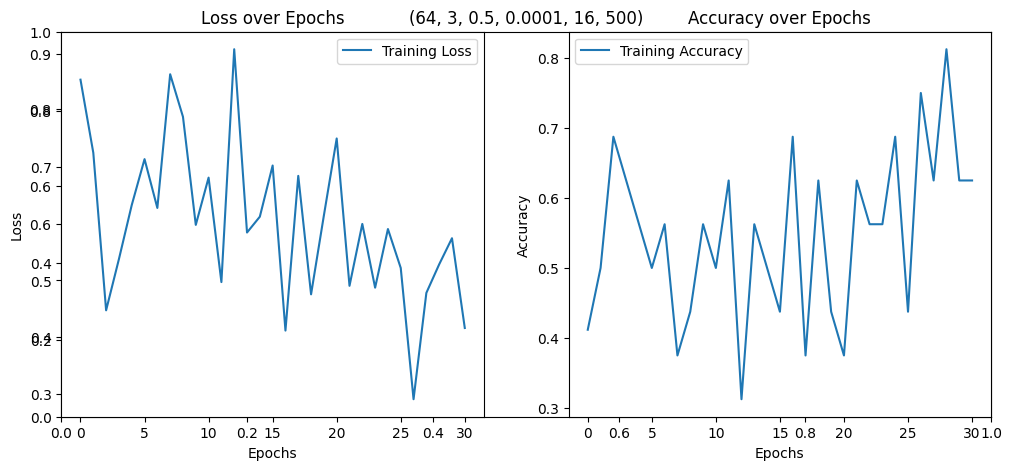

-------------------------------------------------------------


In [597]:
hyperparams = (64, 3, 0.5, 0.0001, 16, 500)
newargs = NewArgs(*hyperparams)
model = GraphMatchingNetwork(newargs)
optimizer = Adam(model.parameters(), lr=newargs.lr, weight_decay=1e-5)
pairs, labels = create_graph_pairs(dataset, newargs.num_pairs)
train(model, optimizer, pairs, labels, newargs.batch_size, str(hyperparams))
# acc_test(model, True, 0.8)
print("-------------------------------------------------------------")
# break

In [566]:
def plot_mutag(
    graph1, graph2=None, original_x1=None, perm1=None, original_x2=None, perm2=None
):
    import matplotlib.patches as mpatches
    import matplotlib

    def plot_single_graph(graph, ax, original_x=None, perm=None):
        G = to_networkx(graph, to_undirected=True)

        colormap = matplotlib.colormaps.get_cmap("Pastel1")

        color_map = {
            0: colormap(0),
            1: colormap(1),
            2: colormap(2),
            3: colormap(3),
            4: colormap(4),
            5: colormap(5),
            6: colormap(6),
        }

        legend_handles = [
            mpatches.Patch(color=colormap(0), label="C"),
            mpatches.Patch(color=colormap(1), label="N"),
            mpatches.Patch(color=colormap(2), label="O"),
            mpatches.Patch(color=colormap(3), label="F"),
            mpatches.Patch(color=colormap(4), label="I"),
            mpatches.Patch(color=colormap(5), label="Cl"),
            mpatches.Patch(color=colormap(6), label="Br"),
        ]

        node_colors = []
        node_labels = {}

        if original_x is not None and perm is not None:
            mapped_x = original_x[perm[: graph.num_nodes]]
            for node in range(graph.num_nodes):
                one_hot = mapped_x[node].tolist()
                node_type = one_hot.index(1)
                node_colors.append(color_map[node_type])
                node_labels[node] = perm[node].item()
        else:
            for node in range(graph.num_nodes):
                one_hot = graph.x[node].tolist()
                node_type = one_hot.index(1)
                node_colors.append(color_map[node_type])
                node_labels[node] = node

        pos = nx.spring_layout(G)
        nx.draw(
            G,
            pos,
            node_color=node_colors,
            with_labels=True,
            labels=node_labels,
            node_size=500,
            font_weight="bold",
            ax=ax,
        )
        ax.legend(handles=legend_handles, loc="best", title="Node Types")

    if graph2 is None:
        fig, ax = plt.subplots()
        plot_single_graph(graph1, ax, original_x1, perm1)
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        plot_single_graph(graph1, axes[0], original_x1, perm1)
        plot_single_graph(graph2, axes[1], original_x2, perm2)
        axes[0].set_title("Graph 1")
        axes[1].set_title("Graph 2")

    plt.show()

In [637]:
print(small_classes["class_1"])

[]


In [628]:
c = f"class_0"
idx1 = random.sample(range(len(small_classes["class_0"])), 1)[0]
idx2 = random.sample(range(len(small_classes["class_1"])), 1)[0]
graph1, graph2 = small_classes["class_0"][idx1], small_classes["class_1"][idx2]
model.eval()

feats_1, edge_index_1 = graph1.x, graph1.edge_index
feats_2, edge_index_2 = graph2.x, graph2.edge_index
sizes_1 = torch.tensor([len(graph1.x)])
sizes_2 = torch.tensor([len(graph2.x)])
emb1, emb2, cluster1, cluster2, layer1, layer2 = model(
    feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
)

ValueError: Sample larger than population or is negative

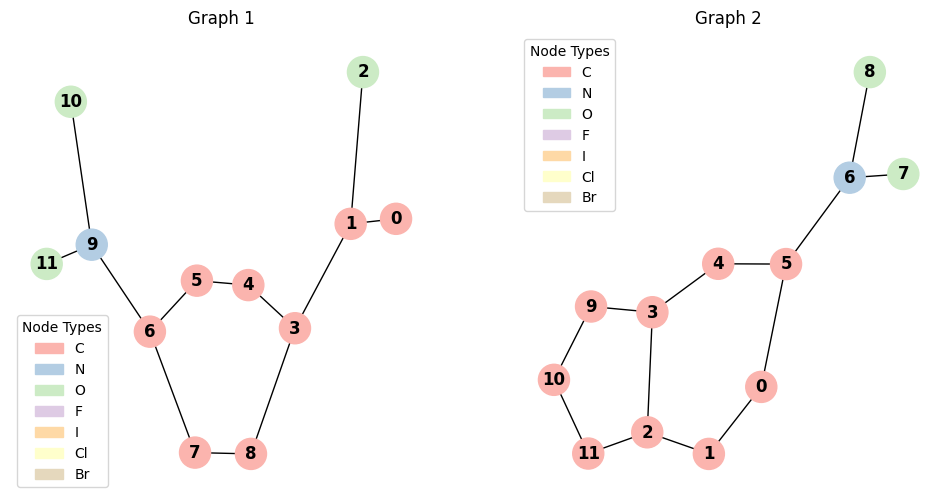

In [625]:
plot_mutag(graph1, graph2)

In [569]:
def extract_embeddings_and_attention(
    model, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
):
    model(feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2)
    embeddings = model.layer_outputs
    attentions = model.layer_cross_attentions
    return embeddings, attentions

In [570]:
def print_attentions(attention_nodes):
    n_layers = len(attention_nodes)
    max_length = max(len(attn_1_to_2) for attn_1_to_2, _ in attention_nodes)

    col_width = 22

    print(" Graph 1 to Graph 2:".ljust(73) + "Graph 2 to Graph 1:")
    print("=" * 72 + " " + "=" * 72)

    for node_idx in range(max_length):
        line_g1_to_g2 = []
        line_g2_to_g1 = []

        for layer_idx in range(n_layers):
            if node_idx < len(attention_nodes[layer_idx][0]):
                attn_1_to_2 = attention_nodes[layer_idx][0][node_idx]
                attn_1_to_2_str = f"{node_idx}: {attn_1_to_2}".ljust(col_width)
            else:
                attn_1_to_2_str = "".ljust(col_width)

            if node_idx < len(attention_nodes[layer_idx][1]):
                attn_2_to_1 = attention_nodes[layer_idx][1][node_idx]
                attn_2_to_1_str = f"{node_idx}: {attn_2_to_1}".ljust(col_width)
            else:
                attn_2_to_1_str = "".ljust(col_width)

            line_g1_to_g2.append(attn_1_to_2_str)
            line_g2_to_g1.append(attn_2_to_1_str)

        g1_to_g2_str = " | ".join(line_g1_to_g2)
        g2_to_g1_str = " | ".join(line_g2_to_g1)
        print(f"{g1_to_g2_str} | {g2_to_g1_str}")

    print("=" * 72 + " " + "=" * 72)

In [616]:
def extract_static_attention_nodes(attentions, k=3):
    attention_nodes = []
    for layer_idx, (cross_graph_attention, a_x, a_y) in enumerate(attentions):
        static_attention_nodes_1_to_2 = []
        static_attention_nodes_2_to_1 = []

        a_x = a_x[0]
        a_y = a_y[0]

        assert a_x.shape[0] == a_y.shape[0]
        assert a_x.shape[1] == a_y.shape[1]

        for i, x_attention in enumerate(a_x):
            if len(x_attention) > k:
                topk_indices = torch.topk(x_attention, k).indices
            else:
                topk_indices = torch.arange(len(x_attention))
            static_attention_nodes_1_to_2.append(topk_indices.tolist())

        for j, y_attention in enumerate(a_y.T):
            if len(y_attention) > k:
                topk_indices = torch.topk(y_attention, k).indices
            else:
                topk_indices = torch.arange(len(y_attention))
            static_attention_nodes_2_to_1.append(topk_indices.tolist())

        attention_nodes.append(
            (static_attention_nodes_1_to_2, static_attention_nodes_2_to_1)
        )

    return attention_nodes

In [626]:
import torch


def extract_dynamic_attention_nodes(attentions, threshold=0.1):
    attention_nodes = []
    for layer_idx, (cross_graph_attention, a_x, a_y) in enumerate(attentions):
        dynamic_attention_nodes_1_to_2 = []
        dynamic_attention_nodes_2_to_1 = []

        a_x = a_x[0]
        a_y = a_y[0]

        assert a_x.shape[0] == a_y.shape[0]
        assert a_x.shape[1] == a_y.shape[1]

        for i, x_attention in enumerate(a_x):
            strong_attention_indices = (x_attention > threshold).nonzero(as_tuple=True)[
                0
            ]
            dynamic_attention_nodes_1_to_2.append(strong_attention_indices.tolist())

        for j, y_attention in enumerate(a_y.T):
            strong_attention_indices = (y_attention > threshold).nonzero(as_tuple=True)[
                0
            ]
            dynamic_attention_nodes_2_to_1.append(strong_attention_indices.tolist())

        attention_nodes.append(
            (dynamic_attention_nodes_1_to_2, dynamic_attention_nodes_2_to_1)
        )

    return attention_nodes


embeddings, attentions = extract_embeddings_and_attention(
    model, feats_1, edge_index_1, feats_2, edge_index_2, sizes_1, sizes_2
)
# attention_nodes = extract_static_attention_nodes(attentions, 4)
attention_nodes = extract_dynamic_attention_nodes(attentions, threshold=0.11)

print_attentions(attention_nodes)

 Graph 1 to Graph 2:                                                     Graph 2 to Graph 1:
======================================================================== ========================================================================
0: []                  | 0: [7, 8]              | 0: []                  | 0: []                  | 0: [4, 5, 7, 8]        | 0: [4, 5, 7, 8]       
1: []                  | 1: [2, 3, 5]           | 1: [2, 3]              | 1: []                  | 1: [4, 5, 7, 8]        | 1: [4, 5, 7, 8]       
2: [7, 8]              | 2: [7, 8]              | 2: []                  | 2: []                  | 2: [1, 3, 6]           | 2: [1, 3]             
3: []                  | 3: [2, 3, 5]           | 3: [2, 3]              | 3: []                  | 3: [1, 3, 6]           | 3: [1, 3]             
4: []                  | 4: [0, 1, 4, 9, 10, 11] | 4: [0, 1, 4, 9, 11]    | 4: []                  | 4: [4, 5, 7, 8]        | 4: [4, 5, 7, 8]       
5: []               

In [627]:
torch.save((graph1, graph2, attention_nodes), "info_new.pt")